### Two approaches for defining a collocation method

The collocation method solves the Dahlquist problem by solving the Picard form of the ODE :

$$u(t_1) = u(t_0) + \int_{t_0}^{t_1} \lambda u(\tau)d\tau$$

using a quadrature rule on some (normalized) nodes $\tau_1, ..., \tau_M \in [0, 1]$ to approximate the integral.

Those nodes can be all strictly contained in $[0,1]$ ($\tau_1 > 0$, $\tau_M < 1$ => GAUSS quadrature type), include only the left boundary ($\tau_1 = 0$, $\tau_M < 1$ => RADAU-I quadrature type), include only the right boundary ($\tau_1 > 0$, $\tau_M = 1$ => RADAU-II quadrature type) or both ($\tau_1 = 0$, $\tau_M = 1$ => LOBATTO quadrature type).

This produces the following discrete equation on each nodes solution :

$$u(\tau_m) = u(t_0) + \int_{t_0}^{\tau_m} \lambda u(\tau)d\tau$$

which provides the algebraic system :

$$(I-\lambda\Delta{t}Q) 
\begin{pmatrix} u(\tau_1)\\ \vdots\\  u(\tau_M) \end{pmatrix}
= \begin{pmatrix} u(t_0)\\ \vdots\\  u(t_0) \end{pmatrix},$$

with $\Delta{t}=t_1-t_0$.

> Now the problem is : depending on wether or not $\tau_M = 1$, we need to find a generic way to compute $u(t_1)$ in order to compute the next time-step (where the current $u(t_1)$ will become the next $u(t_0)$).

To do that, there is two approaches.

**First approach : use a polynomial extrapolation**

Once we have computed the solution at each nodes $\tau_1, ..., \tau_M$, it is like we approximated the solution on $[t_0, t_1]$ using a polynomial represented on $M$ points, *i.e* of order $M-1$.
So we can simply evaluate this polynomial on the last point $t_1$ to get the end-point solution.
This gives us a formula of the form :

$$u(t_1) = \sum_{i=1}^{M} c_i u(\tau_i),$$

where the $c_i$ depends only on the node distribution (and can be computed, for instance, using barycentric interpolation). This gives us a matrix

$$H = 
\begin{pmatrix} 
c_1 & \dots & c_M \\
\vdots & & \vdots \\
c_1 & \dots & c_M \\
\end{pmatrix}$$

such that

$$(I-\lambda\Delta{t}Q) \begin{pmatrix} u(\tau_1)\\ \vdots\\  u(\tau_M) \end{pmatrix} 
= H \begin{pmatrix} u_{prev}(\tau_1)\\ \vdots\\  u_{prev}(\tau_M) \end{pmatrix}$$

where $u_{prev}$ is the solution from the previous time-step interval.

In particular, if $\tau_m=1$, then we have naturally $u(t_1)=u(\tau_m)$ and we can simply copy the value, so the $H$ matrix is simply :

$$H = 
\begin{pmatrix} 
0 & \dots & 0 & 1 \\
\vdots & & \vdots & \vdots \\
0 & \dots & 0 & 1\\
\end{pmatrix}$$

Now, we have our collocation method within the GFM framework with the block vector $\begin{pmatrix} u(\tau_1), \dots,  u(\tau_M) \end{pmatrix}^T$, and

$$
\phi = (I-\lambda\Delta{t}Q), \quad
\chi = H,
$$

and the end-point solution from each interval can be retrieved by taking any element (for instance, first one) of the following vector :

$$
\chi \begin{pmatrix} u_{prev}(\tau_1)\\ \vdots\\  u_{prev}(\tau_M) \end{pmatrix}
$$


**Second approach : use an exact prolongation**

Once we have computed the solution at each nodes $\tau_1, ..., \tau_M$, we can also use the discrete Picard form to compute the end-point solution (at the expense of computing again an approximate quadrature) :

$$u(t_1) = u(t_0) + \int_{t_0}^{t_1} \lambda u(\tau)d\tau$$

Now instead of approximating the solution by a polynomial, we approximate the integral instead using the quadrature rule defined by the nodes :

$$u(t_1) = u(t_0) + \sum_{i=1}^{M} \omega_i u(\tau_i),$$

with $\omega$ the quadrature weights that can be computed directly from the nodes (for instance, by integrating the Lagrange interpolating polynomials).

Here we need $u(t_0)$, which implies that $u(t_1)$ must be considered as an unknown of the collocation problem, similarly as any other $u(\tau_i)$.
So our block vector is then $\begin{pmatrix} u(\tau_1), \dots,  u(\tau_M), u(t_1) \end{pmatrix}^T$ and **necessarily include the end-point solution, independent from the quadrature type** (that is, even when using GAUSS points !).

This implies that 

$$\chi = 
\begin{pmatrix} 
0 & \dots & 0 & 1 \\
\vdots & & \vdots & \vdots \\
0 & \dots & 0 & 1\\
\end{pmatrix}$$

and 

$$
\phi = \begin{pmatrix} 
(I-\lambda\Delta{t}Q) & 0 \\
-\lambda\delta{t}{\bf w} & 1
\end{pmatrix}
$$

with ${\bf w} = (\omega_1, \dots, \omega_M)$

Note that with $M$ nodes, we get now $(M+1 \times M+1)$ matrices for the block operators.

> **Now if we use both approaches to integrate the Dahlquist problem with a given number of quadrature nodes $M$, what is the order of accuracy in function of $M$ and the quadrature type (GAUSS, LOBATTO, ...)**

In [1]:
# Script import setup
import numpy as np
import matplotlib.pyplot as plt
from gfm.base import GFMSolver
plt.rcParams['figure.dpi'] = 100

Let's define a function below that computes the global error on a given interval $[0,T]$, with default value for $T=2\pi$, and $\lambda=i$.
The main parameters are :

- M : number of quadrature nodes
- qType : quadrature type (GAUSS, LOBATTO, ...)
- nodes : node distribution (LEGENDRE, CHEBYCHEV, EQUID, ...)
- exactProlong : wether or not using exact prolongation (second approach) or not (first approach)

In [2]:
def getCollocationError(M, qType, nodes, T=2*np.pi, lam=1j, exactProlong=False):
    err = []
    lDt = []
    
    for l in [1, 2, 4, 8, 16, 32]:
        # Compute time step size
        dt = T/l
        lDt.append(dt)
        # Set up the collocation solver
        solver = GFMSolver(lam=lam, u0=1, dt=dt, L=l)
        if exactProlong:
            # Use exact prolongation for the end point
            # => artificially add end-point to the quadrature nodes => M += 1
            solver.setFineLevel(M=M+1, method='COLLOCATION', qType=qType, nodes=nodes, exactProlong=True)
        else:
            # Don't use exact prolongation for the end point
            solver.setFineLevel(M=M, method='COLLOCATION', qType=qType, nodes=nodes)
        # Compute end time solution for collocation, using the chi operator applied on the last block vector
        uEndNum = (solver.chi @ solver.uFine[-1])[0]
        # Compute end time exact solution using exponential
        uEndExact = np.exp(T*lam)
        # Store error
        err.append(abs(uEndExact-uEndNum))
        
    return err, lDt, solver # returns the solver object for post processing, just in case ...

Now lets look at the first approach (exactProlong=False, default value) for Legendre nodes and each of the four quadrature types :

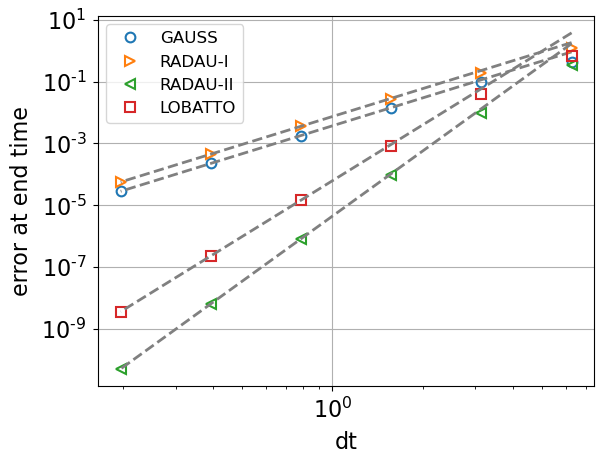

In [3]:
nodes = 'LEGENDRE'
M = 4
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [M-1, M-1, 2*M-1, 2*M-2],
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

We can see the following order of accuracy depending on the quadrature type :

- GAUSS and RADAU-I : order M-1
- RADAU-II : order 2*M-1
- LOBATTO : order 2*M-2

The result for GAUSS and RADAU-I is actually not surprising : since we use a barycentric interpolation of order $M-1$ to compute the end point, this limits the accuracy of the time-stepping method.

For LOBATTO and RADAU-II, this is however different : we don't really use a barycentric interpolation of order $M-1$, because by copying the end-point value we actually use an "exact" interpolation. So the limiting accuracy is the one of the quadrature rule, and since we used LEGENDRE nodes, we retrieve the expected order of accuracy for LOBATTO and RADAU-II nodes.

Now is it the same with the second approach ? Let just store the error for LOBATTO here, and go back at it later ...

In [4]:
err1 = err

Now lets look at the second approach (exactProlong=True) for Legendre nodes and each of the four quadrature types :

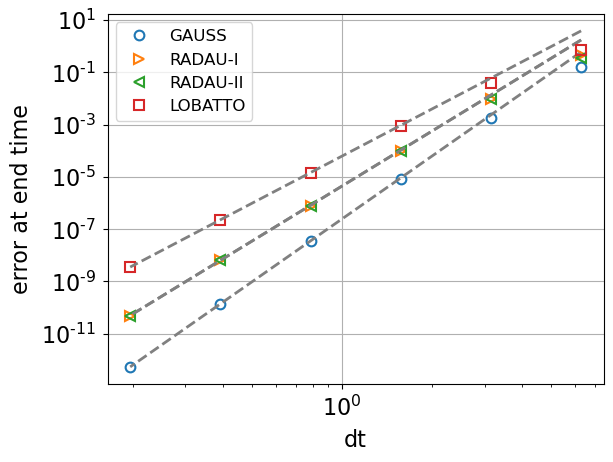

In [5]:
nodes = 'LEGENDRE'
M = 4
for qType, order, sym in zip(['GAUSS', 'RADAU-I', 'RADAU-II', 'LOBATTO'], 
                             [2*M, 2*M-1, 2*M-1, 2*M-2],
                             ['o', '>', '<', 's']):
    err, lDt, solver = getCollocationError(M=M, qType=qType, nodes=nodes, exactProlong=True)
    plt.loglog(lDt, err, sym, label=qType)
    lDt = np.array(lDt)
    c = err[-1]/lDt[-1]**order
    plt.plot(lDt, c*lDt**order, '--', color='gray')

plt.legend()
plt.xlabel('dt')
plt.ylabel('error at end time')
plt.grid()

Now we retrieve the expected order of accuracy for each quadrature type, that is :

- GAUSS : 2*M
- RADAU-I and RADAU-II : 2*M-1
- LOBATTO : 2*M-2

In particular, we get the same order of accuracy for LOBATTO and RADAU-II, independent of the used approach to compute the end-point value.
Also, if we store the last error we have for LOBATTO, compare with what we had for the first approach :

In [6]:
err2 = err
[abs(e1-e2) for e1, e2 in zip(err1, err2)]

[0.0,
 2.636779683484747e-16,
 2.7755575615628914e-17,
 4.024490701630412e-16,
 2.6367775659023786e-16,
 6.453166007726481e-16]

We retrieve exactly the same error up to machine precision, which would indicate that the two approaches are probably equivalent for LOBATTO and RADAU-II nodes.